In [1]:
##################################
#                                #
# regression_TOH.ipynb           #
# Created 2023-05-20             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import pickle
import os
import itertools

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics
from datetime import datetime

import matplotlib.pyplot as plt

#pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
imputation_file = '2024-09-07 AMR_imputation_TOH.xlsx'

data = pd.read_excel(imputation_file)

# From data point 5172 onwards
#data = data[5172:]
#data = data[data['Year (based on culture)']>=2021]

data

,AgeCat,Sex,Year (based on culture),CULTURE_DESCRIPTION,FINAL,PriorGNOrg,ADMIT_SVC,Acquisition,RecentHospitalization,ClinicalESBL,...,Daptomycin_PGNO_imp,Vancomycin_PGNO_imp,Linezolid_PGNO_imp,Amikacin_PGNO_imp,Tobramycin_PGNO_imp,Gentamicin_PGNO_imp,Clindamycin_PGNO_imp,Doxycycline_PGNO_imp,Erythromycin_PGNO_imp,TMPSMX_PGNO_imp
0,60-65,F,2019,BLOOD CULTURE,Pseudomonas aeruginosa,not_applicable,Medical,ICU,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
1,70-75,M,2019,BLOOD CULTURE,Citrobacter freundii,not_applicable,Surgical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
2,80-85,M,2019,ROUTINE CULTURE (AEROBIC SWAB),Morganella morganii,not_applicable,Medical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
3,>90,F,2019,URINE QUANTITATIVE CULTURE,Klebsiella pneumoniae,not_applicable,Medical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
4,80-85,F,2019,BLOOD CULTURE,Escherichia coli,not_applicable,Medical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6605,65-70,M,2023,URINE CULTURE (ADULT),Pseudomonas aeruginosa,not_applicable,Surgical,Hospital,1,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
6606,45-50,M,2023,URINE CULTURE (ADULT),Escherichia coli,not_applicable,Medical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
6607,80-85,F,2023,URINE CULTURE (ADULT),Escherichia coli,not_applicable,Surgical,ICU,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
6608,85-90,F,2023,BLOOD CULTURE,Escherichia coli,not_applicable,Medical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable


In [3]:
# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']
output_antibiotics = ['Meropenem_FINAL_imp','Piptaz_FINAL_imp','Ceftazidime_FINAL_imp','Ceftriaxone_FINAL_imp','Ciprofloxacin_FINAL_imp','Tobramycin_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data[data[abx]=='no_data'].shape[0] / data.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))
    
# Piperacillin-tazobactam or tobramycin missingness
print('{:<15} {:>6.2f}%'.format('Piptaz or tobra',
      data[(data['Piptaz_FINAL_imp']=='no_data')|(data['Tobramycin_FINAL_imp']=='no_data')].shape[0]/data.shape[0]*100))

Missingness
Meropenem         0.00%
Piptaz            2.39%
Ceftazidime       0.41%
Ceftriaxone       1.38%
Ciprofloxacin     0.67%
Tobramycin        4.01%
Piptaz or tobra   5.76%


## Preprocessing

In [4]:
# Add a column for hospital site 
data['hosp_Sunnybrook'] = 0
data['hosp_TOH'] = 1
data['hosp_Trillium'] = 0

In [5]:
# Change missing data in the final output imputation to be resistant
data[output_antibiotics] = data[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data = data.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Convert age to a continuous variable
age_categories = {'<40'  :30, 
                  '40-45':42.5,
                  '45-50':47.5,
                  '50-55':52.5,
                  '55-60':57.5,
                  '60-65':62.5,
                  '65-70':67.5,
                  '70-75':72.5,
                  '75-80':77.5,
                  '80-85':82.5,
                  '85-90':87.5,
                  '>90'  :95
                 }
data['Age'] = data['AgeCat'].replace(age_categories).infer_objects()

# Rename acquisition locations to match future code
data['Acquisition'] = data['Acquisition'].replace({'Community':'community','Hospital':'ward'})

# Rename admitting service to match future code
data['ADMIT_SVC'] = data['ADMIT_SVC'].replace({'Medical':'medical','Surgical':'surgical'})

# One hot encode categories
one_hot_data = pd.get_dummies(data, columns=['Sex','Acquisition','ADMIT_SVC'],
                                        prefix= ['sex','acquisition','adm_service'])

### Encode prior antibiotic exposure

In [6]:
# Create a column of prior exposure to either penicillins or aminoglycosides
conditions = [((one_hot_data['PriorPenicillin']==0) & (one_hot_data['PriorAMG']==0)),
              ((one_hot_data['PriorPenicillin']==1) | (one_hot_data['PriorAMG']==1))]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['PriorPenicillin_or_AMG'] = np.select(conditions, [0,1], default=-1)

# Create new categories of "prior non-[antibiotic class]"
one_hot_data['PriorNonCephalosporin'] = one_hot_data[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonCarbapenem'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonPenicillin'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonFQ'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonAMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonOtherAbx'] = one_hot_data[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

one_hot_data['PriorNonPenicillin_or_AMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorCarbapenem']].any(axis='columns')

### List of antibiotics and classes to run regression on


In [7]:
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']

# New antibiotic list as of 2024-03-26:
antibiotic_list = ['Meropenem','Piptaz','Ceftazidime','Ceftriaxone','Ciprofloxacin']

antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx','Piptaz_or_Tobramycin':'Penicillin_or_AMG'}

In [8]:
# Add a column for combined pip-taz and tobramycin via multiplication    
# (would only be 1 (resistant) if both are 1 (resistant), otherwise 0 (susceptible))
one_hot_data['Piptaz_or_Tobramycin_FINAL_imp'] = (one_hot_data['Piptaz_FINAL_imp'])*(one_hot_data['Tobramycin_FINAL_imp'])

### Handling previous antibiotic exposure and resistance

In [9]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous gram negative organism without susceptibility data
        1 if previous susceptible gram negative organism
        2 if previous resistant gram negative organism 
    '''
    
    if priorGNOrg=='not_applicable': return 0
    elif prior_susceptibility=='no_data': return 0

    # 0 = prior susceptible, 1 = prior resistant
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==0): return 1
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==1): return 2
        
    else: raise ValueError('Inputs passed to the previous_infection function are invalid.')

# Add a column for previous susceptibility to the particular antibiotic
for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

In [10]:
# Special case of piperacillin-tazobactam plus tobramycin

    # 0 if no previous gram negative organism
    # 0 if previous gram negative organism without susceptibility data for either antibiotic
    # 1 if previous resistance to only one of the two antibiotics (the other may be susceptible or have no data)
    # 2 if previous resistance to both antibiotics

# Note that this behaviour is slightly different from the function for single antibiotic susceptibility histories,
    # which would assign a 1 if the previous antibiotic was susceptible

# 0 = prior susceptible, 1 = prior resistant
conditions = [(one_hot_data['PriorGNOrg']=='not_applicable'),              
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==0)),  
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==1))]
values = [0,0,0,0,0,1,1,1,1,2]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['Piptaz_or_TobramycinResistance'] = np.select(conditions, values, default=-1)

# if 'Piptaz_or_Tobramycin' not in antibiotic_list:
#     antibiotic_list.append('Piptaz_or_Tobramycin')

In [11]:
# Convert prior resistance history into one-hot encoding

for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data[antibiotic+'Resistance'].replace({0:'no_prior',
                                                                                           1:'susceptible',
                                                                                           2:'nonsusceptible'
                                                                                          })
    one_hot_data = pd.get_dummies(one_hot_data,columns=[antibiotic+'Resistance'])

### Organisms isolated

In [12]:
one_hot_data['FINAL'].value_counts()

FINAL
Escherichia coli                   3248
Klebsiella pneumoniae               936
Pseudomonas aeruginosa              833
Proteus mirabilis                   305
Enterobacter cloacae                282
                                   ... 
Serratia rubidaea                     1
Raoultella (Klebsiella) species       1
Pasteurella multocida                 1
Comamonas (Pseudomonas) species       1
Neisseria gonorrhoeae                 1
Name: count, Length: 79, dtype: int64

# Regression Function

In [13]:
regression_inputs = ['Age','sex_M',
                     'acquisition_ICU','acquisition_ward',
                     'adm_service_surgical',
                     'RecentHospitalization',
                     
                     'Prior[Class]Exposure','Prior[NonClass]Exposure',
                     '[Antibiotic]_susceptible','[Antibiotic]_nonsusceptible',
                     
                     'ClinicalESBL']

print('Number of regression inputs: {}'.format(len(regression_inputs)))

Number of regression inputs: 11



Logistic regression model for Meropenem:

Logistic Regression Coefficients
MeropenemResistance_nonsusceptible          3.2073
PriorCarbapenem                             2.0751
sex_M                                       0.7142
PriorNonCarbapenem                          0.5550
adm_service_surgical                        0.4533
acquisition_ward                            0.3592
acquisition_ICU                             0.1219
RecentHospitalization                       0.0929
Age                                        -0.0041
MeropenemResistance_susceptible            -0.1467
ClinicalESBL                               -0.4437

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.13
                     median:  0.99
                     mean:    0.98
                     max:     1.00
                     
Resistant isolates   min:     0.16
                     median:  0.97
                     mean:    0.86
                     max:     1.00
          

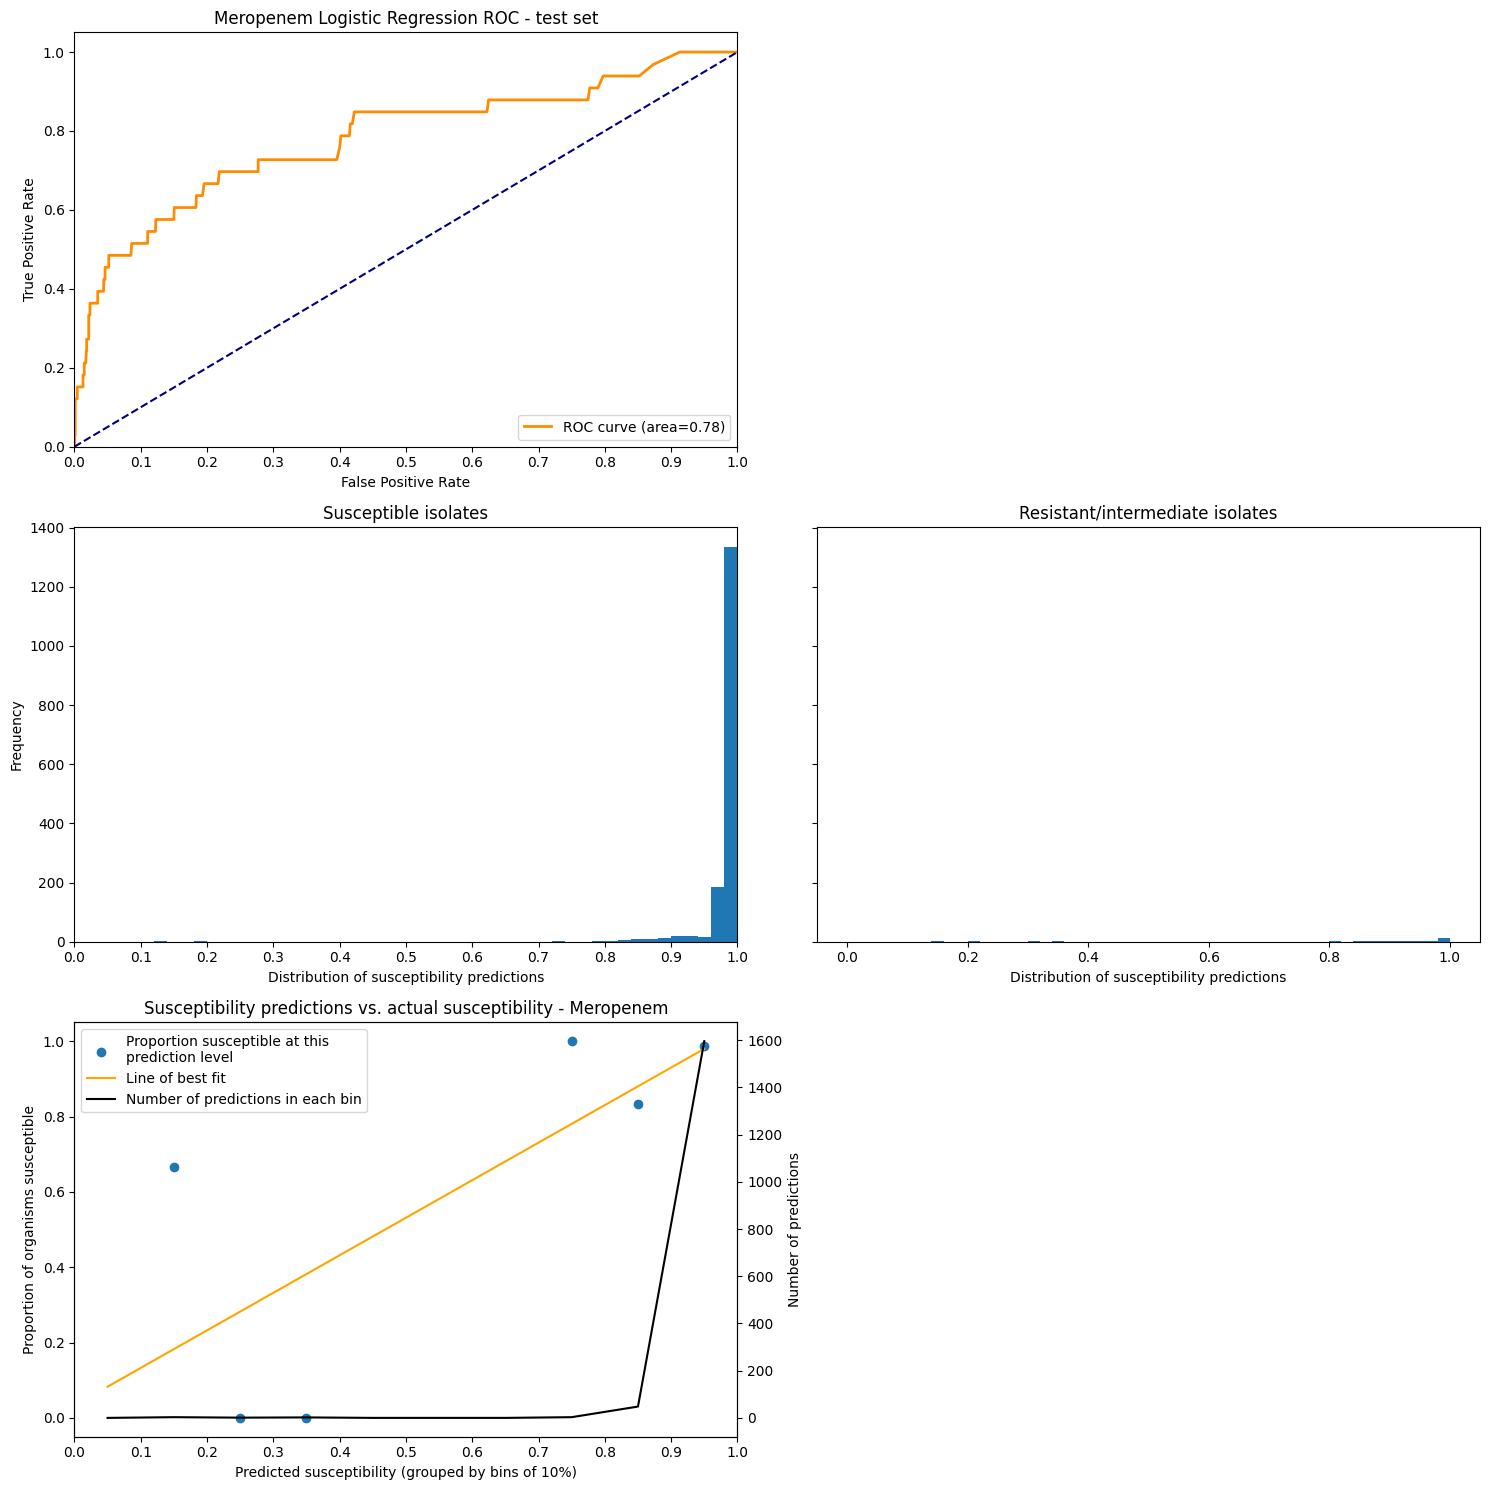


Logistic regression model for Piptaz:

Logistic Regression Coefficients
ClinicalESBL                                1.5912
PiptazResistance_nonsusceptible             1.4301
PriorNonPenicillin                          0.6218
PriorPenicillin                             0.3613
acquisition_ward                            0.0102
Age                                        -0.0011
adm_service_surgical                       -0.0404
acquisition_ICU                            -0.1221
sex_M                                      -0.1517
RecentHospitalization                      -0.1955
PiptazResistance_susceptible               -0.7845

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.12
                     median:  0.87
                     mean:    0.84
                     max:     0.95
                     
Resistant isolates   min:     0.12
                     median:  0.81
                     mean:    0.77
                     max:     0.91
             

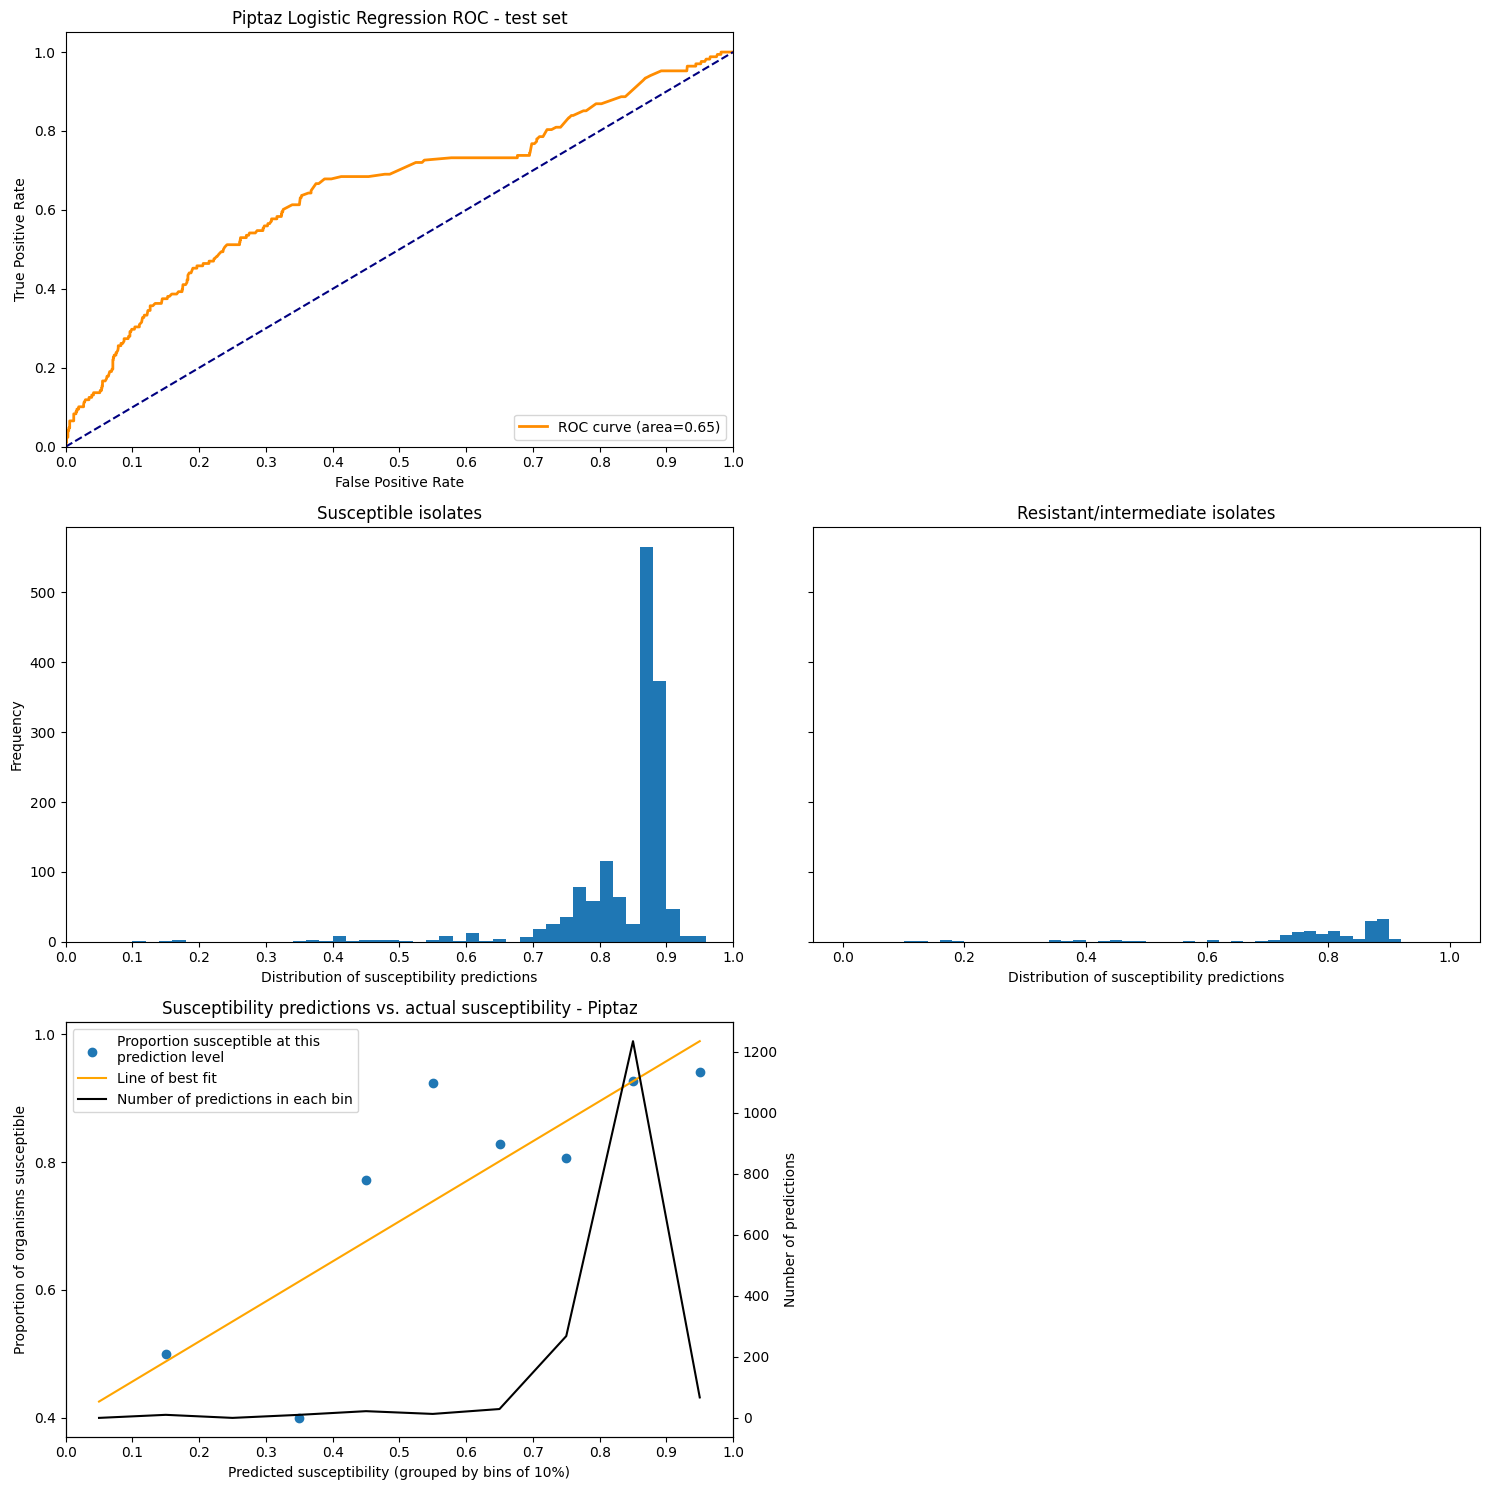


Logistic regression model for Ceftazidime:

Logistic Regression Coefficients
CeftazidimeResistance_nonsusceptible        1.3930
ClinicalESBL                                1.3705
PriorCephalosporin                          0.8114
acquisition_ICU                             0.3662
sex_M                                       0.2883
PriorNonCephalosporin                       0.2151
acquisition_ward                            0.1603
adm_service_surgical                        0.0534
Age                                        -0.0019
RecentHospitalization                      -0.0661
CeftazidimeResistance_susceptible          -1.0119

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.08
                     median:  0.82
                     mean:    0.78
                     max:     0.94
                     
Resistant isolates   min:     0.08
                     median:  0.73
                     mean:    0.64
                     max:     0.92
        

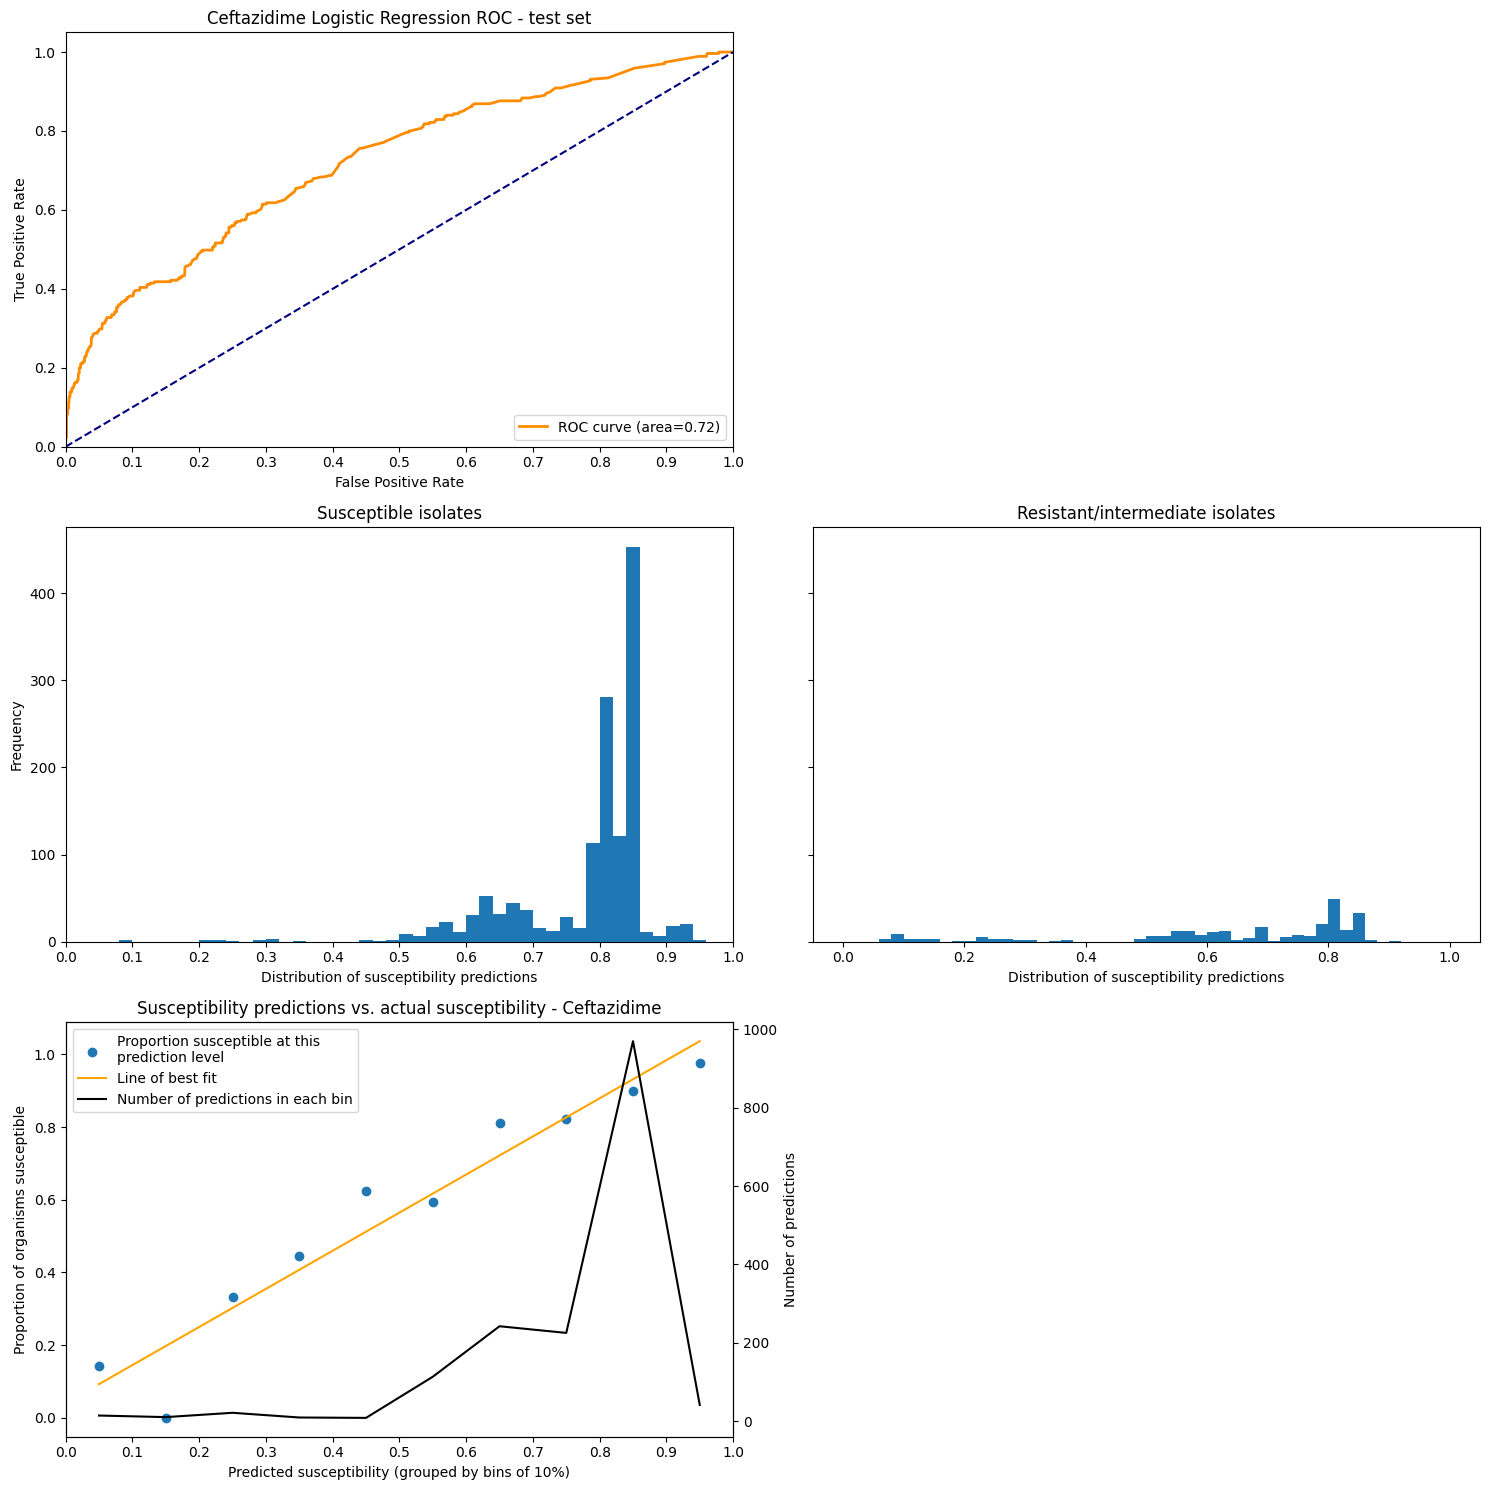


Logistic regression model for Ceftriaxone:

Logistic Regression Coefficients
CeftriaxoneResistance_nonsusceptible        1.3759
ClinicalESBL                                1.3591
PriorCephalosporin                          1.1727
sex_M                                       0.4861
PriorNonCephalosporin                       0.4822
acquisition_ICU                             0.4039
acquisition_ward                            0.0849
adm_service_surgical                        0.0418
Age                                        -0.0045
RecentHospitalization                      -0.2656
CeftriaxoneResistance_susceptible          -1.1721

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.11
                     median:  0.75
                     mean:    0.70
                     max:     0.94
                     
Resistant isolates   min:     0.03
                     median:  0.55
                     mean:    0.52
                     max:     0.90
        

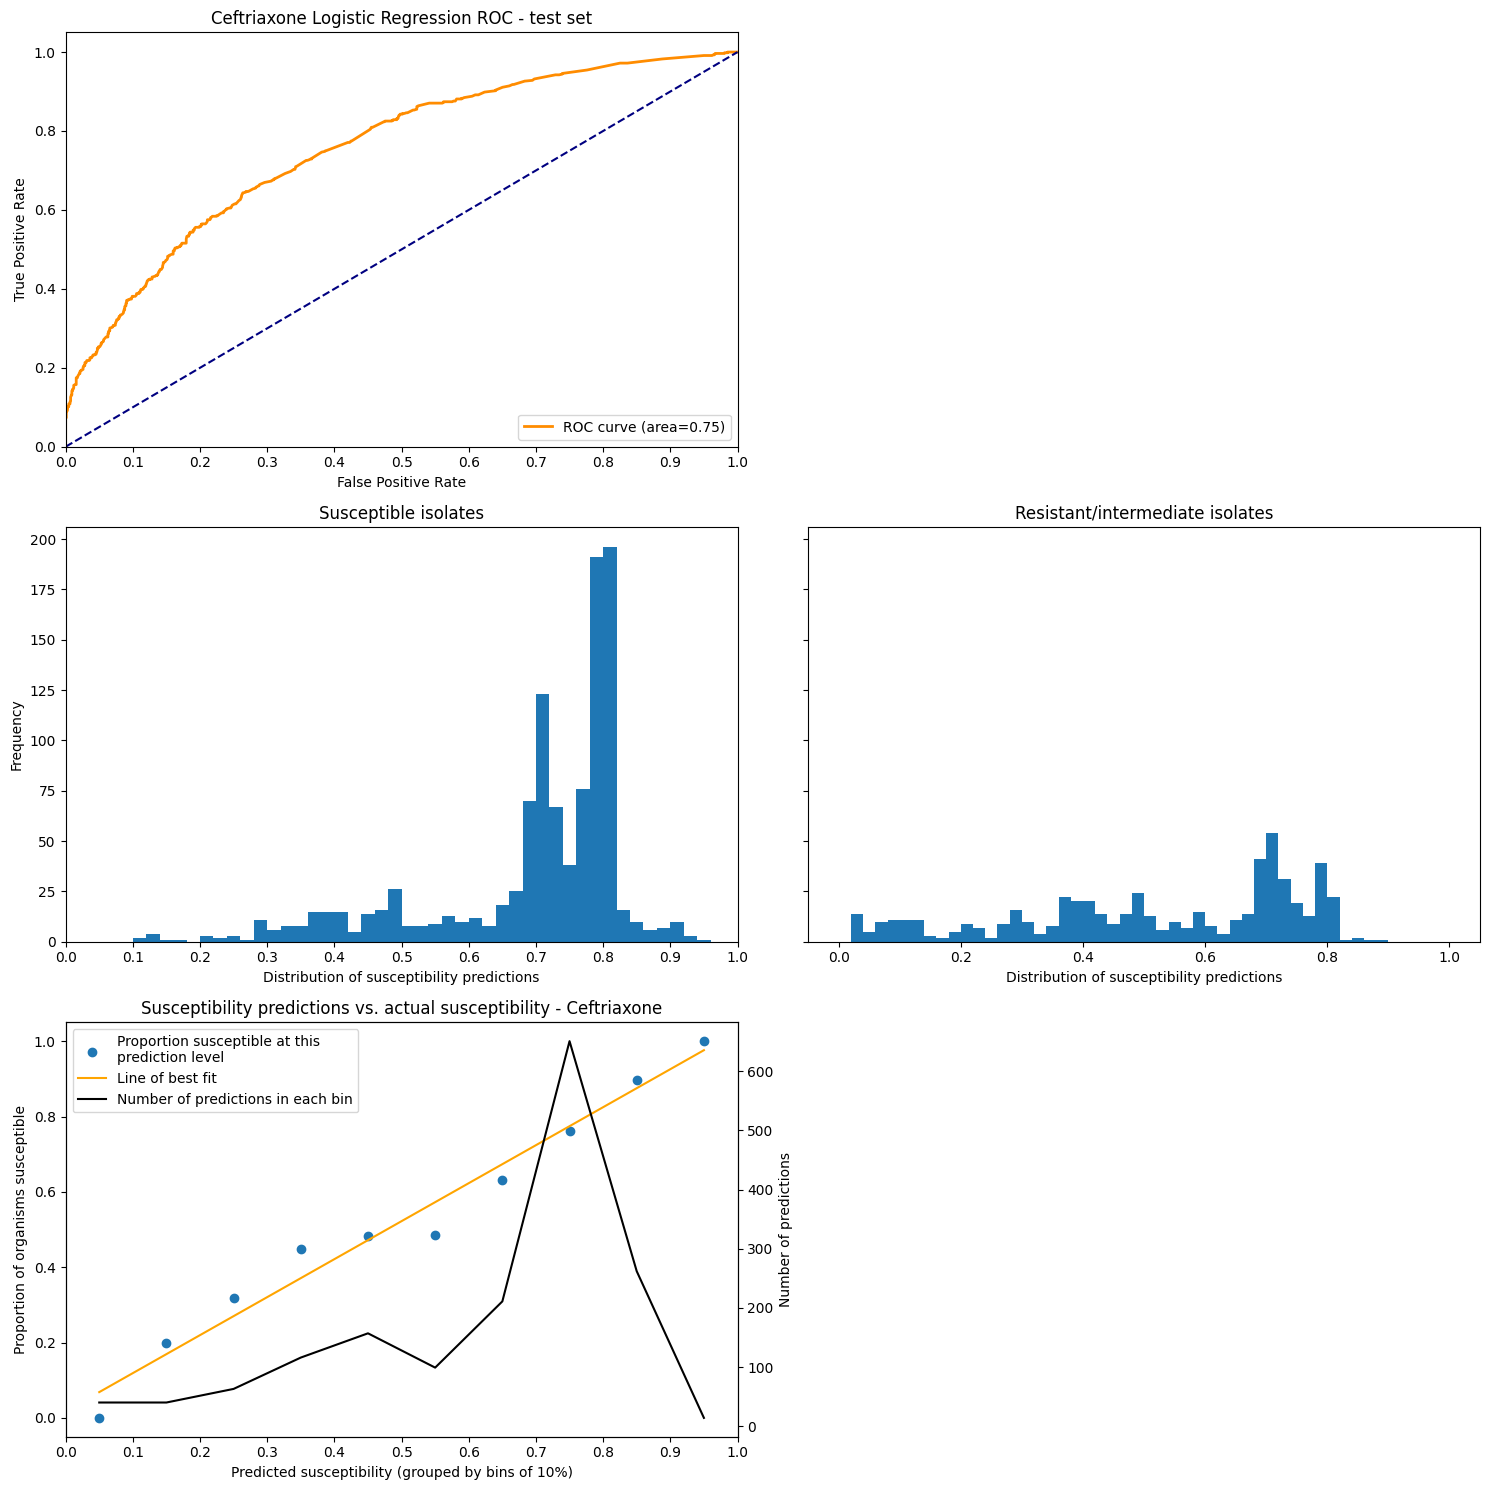


Logistic regression model for Ciprofloxacin:

Logistic Regression Coefficients
CiprofloxacinResistance_nonsusceptible      1.8657
ClinicalESBL                                1.2573
PriorFQ                                     1.1397
PriorNonFQ                                  0.0756
adm_service_surgical                        0.0463
Age                                         0.0029
sex_M                                      -0.1126
RecentHospitalization                      -0.1158
acquisition_ward                           -0.3147
acquisition_ICU                            -0.4587
CiprofloxacinResistance_susceptible        -0.4790

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.15
                     median:  0.80
                     mean:    0.79
                     max:     0.92
                     
Resistant isolates   min:     0.05
                     median:  0.79
                     mean:    0.70
                     max:     0.88
      

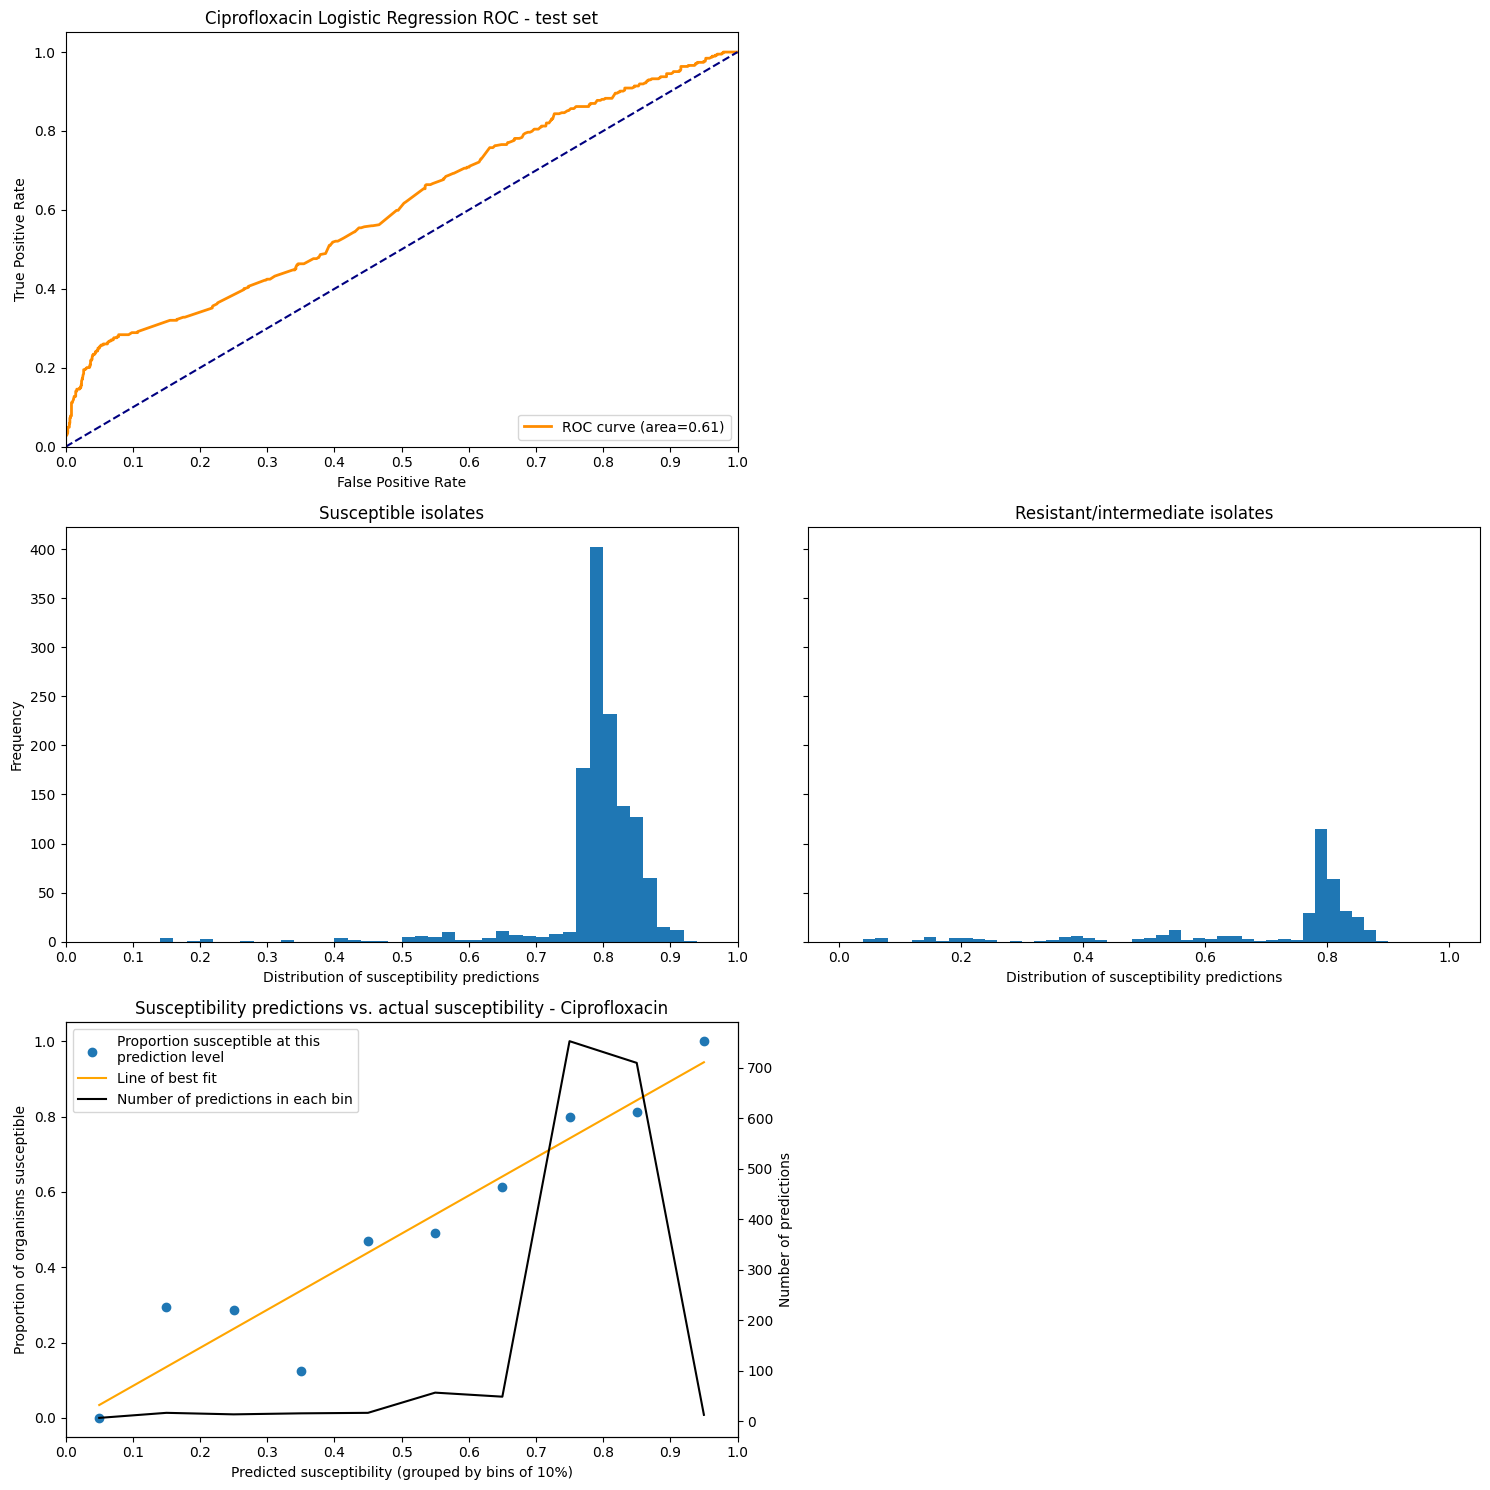

In [14]:
# Divide data into temporal 80-20 train-test sets
# Update 2024-05-23: instead of 80-20 will do 50-50
# Update 2024-06-11: 75-25 split
train_set, test_set= np.split(one_hot_data, [int(.75 *len(one_hot_data))])

# Collect a list of AUCs of the receiver operating characteristic
AUCROCs = []

for antibiotic in antibiotic_list:
    
    print('\nLogistic regression model for {}:\n'.format(antibiotic))
    
    regression_inputs = ['Age','sex_M',                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical','RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL'
                        ]
    
    # 0 = susceptible, 1 = resistant
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']
    
    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(X_train,Y_train)
    
    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))

    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Print descriptive statistics
    print('\nProbability of susceptibility: prediction outputs')

    print('''Susceptible isolates min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                                np.median(susceptible_isolates),
                                np.mean(susceptible_isolates),
                                max(susceptible_isolates)))    
    print('''Resistant isolates   min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                                np.median(resistant_isolates),
                                np.mean(resistant_isolates),
                                max(resistant_isolates)))  

    print('Mean predicted susceptibility of all isolates: {:.2f}'.format(np.mean(list(i[0] for i in predict_results))))

    
    # Generate plots

    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=3,ncols=2, 
                           sharex='col',sharey = "row", 
                           figsize=(15,15))

    ax[0,0].plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].xaxis.set_tick_params(labelbottom=True)    
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0,0].legend(loc="lower right")

    # Calculate and plot ROC based on train set
    fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
    AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))
    AUCROCs.append(AUC)

    '''
    # Calculate and plot ROC based on train set    
    ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,1].set_xlim([0.0, 1.0])
    ax[0,1].set_ylim([0.0, 1.05])
    ax[0,1].set_xticks(np.arange(0,1.1,0.1))
    ax[0,1].xaxis.set_tick_params(labelbottom=True)
    ax[0,1].set_xlabel("False Positive Rate")
    ax[0,1].set_ylabel("True Positive Rate")
    ax[0,1].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
    ax[0,1].legend(loc="lower right")            
    '''
    ax[0,1].axis('off') # Delete this line if we want to see above plot
    
    # Plot a histogram of predictions on susceptible and resistant isolates    
    ax[1,0].hist(susceptible_isolates, bins=50,range=(0,1))    
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of susceptibility predictions')
    ax[1,0].xaxis.set_tick_params(labelbottom=True)    

    ax[1,1].hist(resistant_isolates, bins=50,range=(0,1))
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of susceptibility predictions')
    ax[1,1].xaxis.set_tick_params(labelbottom=True)    

    # Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
    print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))

    # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each
    hist_edges = np.arange(0,1.05,0.1)

    # For later plotting
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)

    # Then, loop over bins
    for i in range(len(hist_edges)-1):

        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1

        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
            print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                          susceptible_number,
                                                          resistant_number,
                                                          percent_susceptible))            
            bin_susceptibilities.append(percent_susceptible)

        except ZeroDivisionError:
            print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
            bin_susceptibilities.append(np.nan)

    print()

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[2,0]
    ax2b = ax[2,0].twinx()

    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')

    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    

    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    

    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

    # Delete the bottom right graph and plot the others
    ax[2,1].axis('off')
    fig.patch.set_facecolor('white') # White background for easier copy/pasting
    plt.tight_layout()
    plt.show()

## Writing the regression model (with _all_ data) to file

In [15]:
for antibiotic in antibiotic_list:

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']

    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(one_hot_data[regression_inputs],one_hot_data[antibiotic+'_FINAL_imp'])

    # Print logistic regression coefficients sorted by size
    print('Logistic Regression Coefficients for {}'.format(antibiotic))
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<46} {: .4f}'.format(i[1],i[0]))
    print()
    
    # Save the regression model to pickle
    with open(antibiotic+'_TOH.pickle','wb') as reg_file:
        pickle.dump(reg,reg_file)

Logistic Regression Coefficients for Meropenem
MeropenemResistance_nonsusceptible              3.0168
PriorCarbapenem                                 2.0497
PriorNonCarbapenem                              0.7413
sex_M                                           0.6349
acquisition_ICU                                 0.3212
adm_service_surgical                            0.3038
acquisition_ward                                0.1579
Age                                            -0.0048
RecentHospitalization                          -0.0868
MeropenemResistance_susceptible                -0.2095
ClinicalESBL                                   -0.6673

Logistic Regression Coefficients for Piptaz
ClinicalESBL                                    1.3921
PiptazResistance_nonsusceptible                 1.3884
PriorNonPenicillin                              0.6148
PriorPenicillin                                 0.3828
acquisition_ward                                0.0465
acquisition_ICU             

## Quality assurance of the model on previous isolates

In [16]:
for antibiotic in antibiotic_list:
    with open(antibiotic+'_TOH.pickle','rb') as f:
        reg = pickle.load(f)

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']
    
    regression_values = one_hot_data[regression_inputs]

    one_hot_data['Predicted'+antibiotic+'Susceptibility'] = reg.predict_proba(regression_values)[:,0]


# QA_data = original_data.join(one_hot_data[['Predicted'+antibiotic+'Susceptibility' for antibiotic in antibiotic_list]])

date = datetime.today().strftime('%Y-%m-%d')
one_hot_data.to_excel(date+' QA data_TOH.xlsx',freeze_panes=(1,0),index=False)
